### Задание

*Данные*  
В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.  
Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.  
Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц. 
Итого, в качестве входных данных будут представлены:  
●	data_train.csv: id, vas_id, buy_time, target  
●	features.csv.zip: id, <feature_list> 

И тестовый набор:  
●	data_test.csv: id, vas_id, buy_time  
target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно.   
buy_time - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция   datetime.fromtimestamp из модуля datetime.  
id - идентификатор абонента  
vas_id - подключаемая услуга  
Примечание: Размер файла features.csv в распакованном виде весит 20 гб, для работы  с ним можно воспользоваться pandas.read_csv, либо можно воспользоваться библиотекой Dask.

Метрика  
Скоринг будет осуществляться функцией f1, невзвешенным образом, как например делает функция sklearn.metrics.f1_score(…, average=’macro’).  
 sklearn.metrics.f1_score — scikit-learn 0.22.1 documentation

In [31]:
!pip install dask[dataframe]
from dask import dataframe as dd

#### Загрузка библиотек

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
%config InlineBackend.figure_format = 'svg'

import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from catboost import CatBoostClassifier, cv, Pool

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

# 6. Всякие разности
from sklearn.preprocessing import LabelEncoder

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.preprocessing import Binarizer
from  sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix, roc_curve, auc
from catboost import CatBoostClassifier
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, SelectKBest, chi2

In [4]:
from lightgbm import LGBMClassifier

Путь к данным

In [5]:
TRAIN_DATASET_PATH = './data_train.csv'
TEST_DATASET_PATH = './data_test.csv'
FEATURES_DATASET_PATH = './features.csv'

Оптимизация объема памяти, занимаемого датасетом

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

Функции

In [7]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [8]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (14, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

#### Загрузка данных (с помощью библиотеки dask)

In [9]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)

In [10]:
df_train.head()

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0
3,3,3535012,5.0,1535922000,0.0
4,4,1693214,1.0,1535922000,0.0


In [11]:
df_train.shape

(831653, 5)

In [12]:
df_train['target'].value_counts(normalize=True)

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

In [13]:
df_test = pd.read_csv(TEST_DATASET_PATH)

In [14]:
df_test.head()

,Unnamed: 0,id,vas_id,buy_time
0,0,3130519,2.0,1548018000
1,1,2000860,4.0,1548018000
2,2,1099444,2.0,1546808400
3,3,1343255,5.0,1547413200
4,4,1277040,2.0,1546808400


In [15]:
df_test.shape

(71231, 4)

Количество строк в датасетах:

In [16]:
print('Строк в трейне:', df_train.shape[0])
print('Строк в тесте', df_test.shape[0])

Строк в трейне: 831653
Строк в тесте 71231


In [33]:
df_features = dd.read_csv(FEATURES_DATASET_PATH, delimiter='\t')

In [34]:
df_features.head()

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


Объединяем трейновые и тестовые данных с фичами

In [35]:
features_trainusers = df_features.loc[df_features['id'].isin(df_train['id'])].compute()

In [36]:
features_trainusers.shape

(834168, 256)

In [37]:
df_train_with_features = pd.merge_asof(df_train.sort_values('id'),features_trainusers.sort_values('id'),
                        on='id')

In [38]:
reduce_mem_usage(df_train_with_features)
df_train_with_features.head()

Memory usage of dataframe is 1656.05 MB
Memory usage after optimization is: 831.20 MB
Decreased by 49.8%


,Unnamed: 0_x,id,vas_id,buy_time_x,target,Unnamed: 0_y,buy_time_y,0,1,2,...,243,244,245,246,247,248,249,250,251,252
0,116,2,2.0,1545598800,0.0,2966746,1545598800,-96.799973,229.530884,-110.740784,...,2300.626221,1492.229248,-21.996269,-35.630447,368.252289,11.167111,7.305572,-12.175933,-0.45614,0.0
1,213,4,1.0,1533502800,0.0,1005270,1538341200,-96.799973,-323.429108,-110.740784,...,4806.625977,4140.229004,-25.996269,-37.630447,-35.747723,-20.832888,-0.694429,-7.175933,-0.45614,0.0
2,499,15,1.0,1534107600,0.0,3686924,1531688400,260.810028,186.710892,249.409210,...,-381.373840,-613.770813,-24.996269,-31.630449,-212.747726,108.167114,-0.694429,107.824066,13.54386,1.0
3,513,16,2.0,1540760400,0.0,1747371,1548018000,152.050034,257.220886,195.609207,...,3185.626221,-613.770813,-21.996269,-37.630447,-139.747726,-24.832888,-0.694429,-12.175933,-0.45614,0.0
4,904,29,1.0,1533502800,0.0,1321339,1532898000,-52.309971,-230.219116,-36.590786,...,-847.373840,-509.770782,-25.996269,-37.630447,-233.747726,-10.832889,-0.694429,2.824067,-0.45614,0.0


In [39]:
df_train_with_features.shape

(831653, 260)

In [40]:
features_testusers = df_features.loc[df_features['id'].isin(df_test['id'])].compute()

In [41]:
features_testusers.shape

(72552, 256)

In [42]:
df_test_with_features = pd.merge_asof(df_test.sort_values('id'),features_testusers.sort_values('id'),
                        on='id')

In [43]:
reduce_mem_usage(df_test_with_features)
df_test_with_features.head()

Memory usage of dataframe is 141.30 MB
Memory usage after optimization is: 70.92 MB
Decreased by 49.8%


,Unnamed: 0_x,id,vas_id,buy_time_x,Unnamed: 0_y,buy_time_y,0,1,2,3,...,243,244,245,246,247,248,249,250,251,252
0,87,55,2.0,1547413200,3374269,1533502800,-42.559971,99.460884,-43.780785,72.293205,...,-927.373840,-570.770813,-24.996269,-36.630447,-212.747726,-14.832889,-0.694429,-1.175933,-0.45614,1.0
1,98,64,4.0,1548018000,1298981,1532293200,71.840027,1048.560913,117.219215,1161.203247,...,-115.373848,-220.770798,761.003723,-37.630447,3790.252197,-5.832889,-0.694429,7.824067,-0.45614,0.0
2,278,151,2.0,1547413200,2460992,1545598800,-90.439972,77.750885,-104.380783,240.403198,...,-914.373840,-613.770813,-25.996269,-6.630448,-14.747724,-24.832888,0.305571,-12.175933,-0.45614,1.0
3,552,274,4.0,1548018000,4183869,1540760400,-25.609970,-123.419113,-39.550785,-176.026794,...,-408.373840,-108.770790,-25.996269,-37.630447,-230.747726,-0.832889,-0.694429,-12.175933,-0.45614,0.0
4,551,274,2.0,1547413200,4183869,1540760400,-25.609970,-123.419113,-39.550785,-176.026794,...,-408.373840,-108.770790,-25.996269,-37.630447,-230.747726,-0.832889,-0.694429,-12.175933,-0.45614,0.0


In [44]:
df_test_with_features.shape

(71231, 259)

Сохраним полученные датасеты для последующей работы:

In [45]:
#df_train_with_features.to_csv('train_with_features.csv')

In [46]:
#df_test_with_features.to_csv('test_with_features.csv')

Загрузим обработанные датасеты (если есть уже обработанные данные):

In [47]:
#df_train_with_features = pd.read_csv('train_with_features.csv')
#reduce_mem_usage(df_train_with_features)
#df_train_with_features.head()

In [48]:
#df_test_with_features = pd.read_csv('test_with_features.csv')
#reduce_mem_usage(df_test_with_features)
#df_test_with_features.head()

Baseline моделирование

*Логистическая регрессия*

In [49]:
data = df_train_with_features.copy()
X = data.drop('target', axis=1)
y = data['target']

X.shape, data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831653 entries, 0 to 831652
Columns: 260 entries, Unnamed: 0_x to 252
dtypes: float32(255), int32(5)
memory usage: 831.2 MB


((831653, 259), None)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, shuffle=True)

class_balance = y.value_counts().to_dict()
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y= y_train)
class_balance, class_weights

({0.0: 771467, 1.0: 60186}, array([0.53900794, 6.90895226]))

In [51]:
def print_score(_y_tst, _y_prdct):
    sp= [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    res=[]
    for s in sp:
        res.append(f1_score(_y_tst, _y_prdct > s, average='macro'))
    print(res)
    return

def run_cv(estimator, cv, _X, _y, scoring='f1_macro', model_name=""):
    cv_res = cross_validate(estimator, _X, _y, cv=cv, scoring=scoring, n_jobs=-1)  
    print("%s: %s = %0.4f (+/- %0.4f)" % (model_name, scoring, cv_res['test_score'].mean(), cv_res['test_score'].std() * 2))
    return cv_res['test_score'].mean()

def lists_diff(left, right):
    return list(set(left) - set(right))

def list_sub(l, r):
    return [item for item in l if item not in r]

def list_common(a, b):   
    a_set = set(a)
    b_set = set(b)     
    # check length
    if len(a_set.intersection(b_set)) > 0:
        return list(a_set.intersection(b_set))
    else:
        return None

def get_val_count(subst, num):
    _nunique = subst.apply(lambda x: x.nunique(dropna=False))    
    return subst[_nunique[_nunique==num].index.to_list()].columns.to_list()

def val_count_in_interval(subst, lft, right):
    _nunique = subst.apply(lambda x: x.nunique(dropna=False))    
    return subst[_nunique[(_nunique>=lft) & (_nunique<=right)].index.to_list()].columns.to_list()

def lst_isin(a, b):
    return list(set(a + b))

def get_n_first_fets(n, f_lst):
  _cutted = []
  for el in f_lst:
    _cutted = _cutted + el[0:n+1]
  _selected = list(set(_cutted))
  print(len(_selected), _selected)
  return _selected

In [52]:
def run_grid_search(estimator, _X, _y, params_grid, cv, scoring='f1_macro'):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=-1)
    gsc.fit(_X, _y)
    print("Best %s score: %.2f" % (scoring, gsc.best_score_))
    print()
    print("Best parameters set found on development set:")
    print()
    print(gsc.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for i, params in enumerate(gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))
    print()    
    return gsc

# Посмотрим точность на кросс-валидации и важность признаков
def extract_features_scores(model, data, target, model_type, column_names=None, cvtreshold=None, cvscore=None):
    assert column_names is not None, "column_names not found"   
    
    if cvscore is None:
      cvscore = run_cv(estimator=model, cv=kfold_cv_stra, _X=data, _y=target, scoring='f1_macro', model_name=model_type)  

    if cvtreshold is None:
      cvtreshold = cvscore

    fe = pd.DataFrame() 
    
    if cvscore >= cvtreshold:    
        model.fit(data, target)        
        if model_type == 'cb':           
            fe = pd.DataFrame(data={'score': model['catboostclassifier'].feature_importances_}, index=column_names).sort_values(by='score', key=abs, ascending=False)     
        elif model_type == 'lr':
            fe = pd.DataFrame(data={'score': model['logisticregression'].coef_[0]}, index=column_names).sort_values(by='score', key=abs, ascending=False)   
        elif model_type == 'lgbm': 
            fe = pd.DataFrame(data={'score': model['lgbmclassifier'].feature_importances_}, index=column_names).sort_values(by='score', key=abs, ascending=False)   
        elif model_type == 'gb':
            fe = pd.DataFrame(data={'score': model['gradientboostingclassifier'].feature_importances_}, index=column_names).sort_values(by='score', key=abs, ascending=False)   
        else:
            raise KeyError('Unknown model_type')

        fe.iloc[0:50].plot(kind='barh', grid=True, figsize=(6,6), legend=False)
        # print(fe.head(10))

        if fe.shape[0] > 0:
          fe_mt_0 = fe.loc[fe.score.abs()>0]
          print("features with non 0 importance:", fe_mt_0.shape)

    return fe, fe_mt_0.index.to_list()    

In [53]:
def columns_by_dtypes_freq(ds:pd.DataFrame, _droplist:list):

    print(f"dataset: {ds.shape} drop: {_droplist}")
   
    _X_nunique = ds.apply(lambda x: x.nunique(dropna=False))

    _const = ds[_X_nunique[ _X_nunique==1].index.to_list()].columns.to_list()
    _unnamed = [c for c in X.columns if ':' in c]
    _ids = [c for c in X.columns if 'id' in c]
    _itimes = [c for c in X.columns if 'time' in c and 'd' not in c] 

    _droplist = _droplist + _const + _ids + _unnamed
    print(f"Added to drop list: {_droplist}") 

    ds = ds.drop(columns=_droplist, axis=1, errors='ignore')
    print(f"Removed: {ds.shape}")

    _X_nunique = ds.apply(lambda x: x.nunique(dropna=False))
    _num_binary = ds[_X_nunique[ _X_nunique==2].index.to_list()].columns.to_list()
    _num_3_10 = ds[_X_nunique[ (_X_nunique>2) & (_X_nunique<=10)].index.to_list()].columns.to_list()
    _num_10_20 = ds[_X_nunique[ (_X_nunique>10) & (_X_nunique<=20)].index.to_list()].columns.to_list()
    
    _objs = ds.select_dtypes(include=['object']).columns.to_list()
    _cat =  ds.select_dtypes(include=['category']).columns.to_list()
    _floats=lists_diff(ds.select_dtypes(include=['float16', 'float32', 'float64']).columns.to_list(), _itimes)
    _ints= lists_diff(ds.select_dtypes(include=['int64','int32','int16','int8']).columns.to_list(), _itimes)
    _bools= ds.select_dtypes(include=['bool']).columns.to_list()    

    print("f_floats", len(_floats), _floats)
    print("f_num_binary", _num_binary, len(_num_binary))
    print("f_num_3_10", _num_3_10, len(_num_3_10)) # low-valiancy or category?
    print("f_num_10_20", _num_10_20, len(_num_10_20))
    if len(_cat):
      print("f_cat", _cat, len(_cat))
    if len(_ints):
      print("f_ints", _ints, len(_ints)) 
    print("f_itimes", _itimes, len(_itimes))
    print("f_unnamed", _unnamed, len(_unnamed))
    if len(_bools):
      print("f_bools", _bools, len(_bools))
    if len(_objs):
      print("f_objs", _objs, len(_objs))

    return _floats, _num_binary, _num_3_10, _num_10_20, _cat, _objs, _ints, _itimes, _bools #, _unnamed

In [54]:
class DateExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
      X_=X.copy()
      rs_col = []
      for c in self.columns:        
        dtc = f"dt{c}"
        X_[dtc] = X_[c].astype('datetime64[s]')
        X_[f"{c}_weekday"] = X_[dtc].dt.weekday
        X_[f"{c}_month"] = X_[dtc].dt.month
        X_[f"{c}_week"] = X_[dtc].dt.week 

        X_[f"{c}_weekday"] = X_[f"{c}_weekday"].astype(np.int8)
        X_[f"{c}_month"] = X_[f"{c}_month"].astype(np.int8)
        X_[f"{c}_week"] = X_[f"{c}_week"].astype(np.int8)

        rs_col = rs_col +[f"{c}_weekday", f"{c}_month", f"{c}_week"]
      rs = X_.drop(columns=self.columns)
      return X_[rs_col]
     

In [55]:
f_service = ['vas_id']
f_target = 'target'
print("f_service", f_service, len(f_service))
print(f_target)

b = "buy_time"
p = "profile_time"
f_dates_extracted = [f'{b}_weekday', f'{b}_month', f'{b}_week'] + [f'{p}_weekday', f'{p}_month', f'{p}_week']

f_floats, f_num_binary, f_num_3_10, f_num_10_20, f_cat, f_objs, f_ints, f_itimes, f_bools = columns_by_dtypes_freq(ds=X_train, _droplist=[])

y_traindf = pd.DataFrame(columns=[f_target], data=y_train)
y_testdf = pd.DataFrame(columns=[f_target], data=y_test)

f_base = f_floats +f_service+f_ints
print("f_base", len(f_base), f_base)
print("f_dates_extracted", len(f_dates_extracted), f_dates_extracted)
print()

f_service ['vas_id'] 1
target
dataset: (557207, 259) drop: []
Added to drop list: ['75', '81', '85', '139', '203', 'id', 'vas_id', 'Unnamed: 0_x', 'Unnamed: 0_y']
Removed: (557207, 250)
f_floats 248 ['33', '108', '223', '140', '232', '41', '109', '36', '190', '146', '179', '53', '155', '44', '196', '136', '239', '156', '228', '219', '123', '234', '184', '32', '92', '193', '116', '128', '251', '70', '130', '199', '202', '238', '141', '100', '143', '163', '194', '166', '220', '231', '144', '160', '210', '74', '47', '97', '3', '13', '4', '82', '215', '9', '178', '212', '55', '77', '83', '30', '87', '93', '200', '58', '64', '147', '217', '23', '154', '170', '31', '54', '61', '197', '180', '18', '69', '63', '76', '119', '240', '168', '43', '204', '192', '235', '66', '80', '39', '15', '165', '191', '185', '211', '137', '138', '172', '237', '89', '159', '161', '218', '145', '125', '252', '1', '40', '150', '241', '221', '127', '152', '106', '245', '68', '118', '6', '12', '48', '10', '57', '209

In [56]:
prep_simple = make_column_transformer(   
    (make_pipeline(SimpleImputer(strategy="mean")), f_base),   
    (make_pipeline(DateExtractor(columns=f_itimes)), f_itimes),
remainder="drop")

prep_lg = make_column_transformer(   
    (make_pipeline(SimpleImputer(strategy="mean"), StandardScaler()), f_base),   
    (make_pipeline(DateExtractor(columns=f_itimes)), f_itimes),
remainder="drop")

In [57]:
kfold_cv_stra = StratifiedKFold(n_splits=3, shuffle=True)

f_base_with_dates_extracted = f_base+ f_dates_extracted
print(len(f_base_with_dates_extracted), f_base_with_dates_extracted)

255 ['33', '108', '223', '140', '232', '41', '109', '36', '190', '146', '179', '53', '155', '44', '196', '136', '239', '156', '228', '219', '123', '234', '184', '32', '92', '193', '116', '128', '251', '70', '130', '199', '202', '238', '141', '100', '143', '163', '194', '166', '220', '231', '144', '160', '210', '74', '47', '97', '3', '13', '4', '82', '215', '9', '178', '212', '55', '77', '83', '30', '87', '93', '200', '58', '64', '147', '217', '23', '154', '170', '31', '54', '61', '197', '180', '18', '69', '63', '76', '119', '240', '168', '43', '204', '192', '235', '66', '80', '39', '15', '165', '191', '185', '211', '137', '138', '172', '237', '89', '159', '161', '218', '145', '125', '252', '1', '40', '150', '241', '221', '127', '152', '106', '245', '68', '118', '6', '12', '48', '10', '57', '209', '11', '129', '46', '59', '243', '19', '62', '225', '110', '96', '157', '120', '181', '65', '112', '134', '115', '67', '29', '24', '117', '226', '2', '195', '121', '7', '151', '216', '26', '99'

In [58]:
lr_ppl = make_pipeline(
  prep_lg,    
  LogisticRegression(penalty='l1', C=1.0e-15, solver='saga', class_weight=class_balance, n_jobs=-1)
)
mcv = run_cv(estimator=lr_ppl, cv=kfold_cv_stra, _X=X_train, _y=y_train, scoring='f1_macro', model_name="baseline logrg")

baseline logrg: f1_macro = 0.4812 (+/- 0.0000)


lr: f1_macro = 0.4812 (+/- 0.0000)
features with non 0 importance: (0, 1)


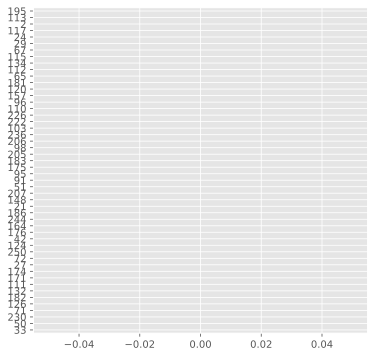

In [59]:
fi_lr, fi_lr_mt_0_cols = extract_features_scores(model=lr_ppl, data=X_train, target=y_train, column_names=f_base_with_dates_extracted, model_type='lr', cvscore=None)

In [60]:
fi_lr

,score
33,0.0
50,0.0
230,0.0
71,0.0
126,0.0
...,...
165,0.0
191,0.0
185,0.0
211,0.0


*Lightgbm*

lgbm: f1_macro = 0.5296 (+/- 0.0072)
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.561614 seconds.
You can set `force_col_wise=true` to remove the overhead.
features with non 0 importance: (200, 1)


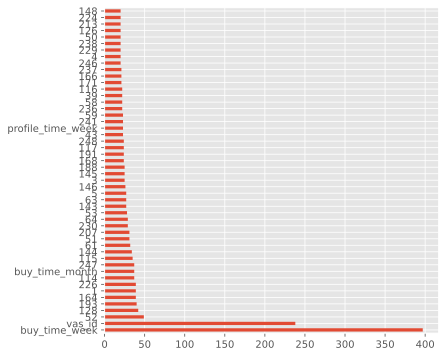

In [61]:
lgbm_ppl = make_pipeline(
    prep_simple,     
    LGBMClassifier(iterations=100, n_jobs=-1, class_weight=class_balance, verbose=0, metric="f1_macro") 
)
fe_lgbm, fe_lgbm_mt_cols = extract_f+-eatures_scores(model=lgbm_ppl, data=X_train, target=y_train, column_names=f_base_with_dates_extracted, model_type='lgbm')

In [62]:
fe_lgbm

,score
buy_time_week,397
vas_id,238
52,49
128,42
193,40
...,...
212,0
83,0
30,0
87,0


*Catboost*

cb: f1_macro = 0.7143 (+/- 0.0019)
features with non 0 importance: (178, 1)


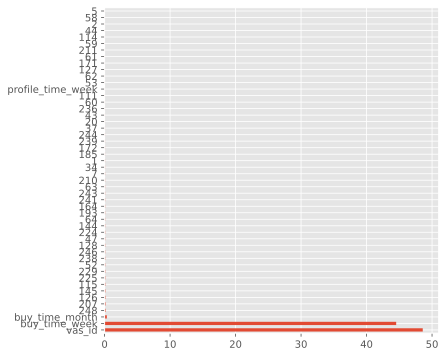

In [63]:
cb_ppl = make_pipeline(
      prep_simple,  
      CatBoostClassifier(iterations=100, thread_count=8, class_weights=class_weights, silent=True, eval_metric="F1") 
)
fi_cb, fi_cb_mt_cols = extract_features_scores(model=cb_ppl, data=X_train, target=y_train, column_names=f_base_with_dates_extracted, model_type='cb', cvtreshold=None, cvscore=None)

In [64]:
fi_cb

,score
vas_id,48.580693
buy_time_week,44.523949
buy_time_month,0.343769
248,0.145870
207,0.142645
...,...
252,0.000000
218,0.000000
159,0.000000
165,0.000000


Наилучшие результаты по выбранной метрике показала модель, построенная на основе алгоритма catboost. Соответственно выберем ее для итогового моделирования.

#### Построение финальной модели

In [65]:
cb_final_arlystop = make_pipeline(
    prep_simple, 
    CatBoostClassifier(iterations=1000, depth=9, learning_rate=0.1, max_leaves=31, thread_count=8, class_weights=class_weights, silent=True, early_stopping_rounds=10, eval_metric="F1"))

In [66]:
[k for k in cb_final_arlystop.get_params().keys() if 'catboost' in k]

['catboostclassifier',
 'catboostclassifier__iterations',
 'catboostclassifier__learning_rate',
 'catboostclassifier__depth',
 'catboostclassifier__thread_count',
 'catboostclassifier__silent',
 'catboostclassifier__class_weights',
 'catboostclassifier__eval_metric',
 'catboostclassifier__early_stopping_rounds',
 'catboostclassifier__max_leaves']

In [67]:
[k for k in cb_final_arlystop.get_params().keys() if 'pip' in k]

['columntransformer__pipeline-1',
 'columntransformer__pipeline-2',
 'columntransformer__pipeline-1__memory',
 'columntransformer__pipeline-1__steps',
 'columntransformer__pipeline-1__verbose',
 'columntransformer__pipeline-1__simpleimputer',
 'columntransformer__pipeline-1__simpleimputer__add_indicator',
 'columntransformer__pipeline-1__simpleimputer__copy',
 'columntransformer__pipeline-1__simpleimputer__fill_value',
 'columntransformer__pipeline-1__simpleimputer__missing_values',
 'columntransformer__pipeline-1__simpleimputer__strategy',
 'columntransformer__pipeline-1__simpleimputer__verbose',
 'columntransformer__pipeline-2__memory',
 'columntransformer__pipeline-2__steps',
 'columntransformer__pipeline-2__verbose',
 'columntransformer__pipeline-2__dateextractor',
 'columntransformer__pipeline-2__dateextractor__columns']

In [68]:
param_grid = {  "catboostclassifier__depth": [3, 9] }
cb_gsc = run_grid_search(cb_final_arlystop, X_train, y_train, param_grid, kfold_cv_stra)

Best f1_macro score: nan

Best parameters set found on development set:

{'catboostclassifier__depth': 3}

Grid scores on development set:

nan (+/-nan) for {'catboostclassifier__depth': 3}
nan (+/-nan) for {'catboostclassifier__depth': 9}



In [69]:
param_grid = {  "catboostclassifier__iterations": [500, 1000] }
cb_gsc = run_grid_search(cb_final_arlystop, X_train, y_train, param_grid, kfold_cv_stra)

Best f1_macro score: nan

Best parameters set found on development set:

{'catboostclassifier__iterations': 500}

Grid scores on development set:

nan (+/-nan) for {'catboostclassifier__iterations': 500}
nan (+/-nan) for {'catboostclassifier__iterations': 1000}



In [70]:
model = cb_gsc.best_estimator_
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['33', '108', '223', '140',
                                                   '232', '41', '109', '36',
                                                   '190', '146', '179', '53',
                                                   '155', '44', '196', '136',
                                                   '239', '156', '228', '219',
                                                   '123', '234', '184', '32',
                                                   '92', '193', '116', '128',
                                                   '251', '70', ...]),
                                                 ('pipeline-2',
                                              

In [71]:
model.fit(X_train, y_train)
model_y_pred = model.predict_proba(X_test)[:,1]

In [72]:
print_score(y_test, model_y_pred)
print(classification_report(y_test, model_y_pred > 0.5))

[0.5203855565881033, 0.691960371222849, 0.7130746565627653, 0.715294333114299, 0.7179518704350856, 0.7236426684506462, 0.7401560677584045, 0.7551492595792075, 0.7200464804075059, 0.4812288882882099]
              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    254585
         1.0       0.35      0.90      0.51     19861

    accuracy                           0.87    274446
   macro avg       0.67      0.88      0.72    274446
weighted avg       0.94      0.87      0.90    274446



Сохранение модели и прогнозов

In [73]:
from datetime import date

filename = f"model{str(date.today())}"
pickle.dump(model, open(filename, 'wb')) 
print(filename)

model2023-04-02


In [74]:
testdata_pred = model.predict_proba(df_test_with_features)[:,1]
testdata_pred.shape, testdata_pred

((71231,),
 array([0.07820538, 0.32853669, 0.06305081, ..., 0.03921909, 0.03796904,
        0.12376027]))

In [75]:
df_test_with_features['target'] = testdata_pred

In [76]:
df_test_with_features

,Unnamed: 0_x,id,vas_id,buy_time_x,Unnamed: 0_y,buy_time_y,0,1,2,3,...,244,245,246,247,248,249,250,251,252,target
0,87,55,2.0,1547413200,3374269,1533502800,-42.559971,99.460884,-43.780785,72.293205,...,-570.770813,-24.996269,-36.630447,-212.747726,-14.832889,-0.694429,-1.175933,-0.45614,1.0,0.078205
1,98,64,4.0,1548018000,1298981,1532293200,71.840027,1048.560913,117.219215,1161.203247,...,-220.770798,761.003723,-37.630447,3790.252197,-5.832889,-0.694429,7.824067,-0.45614,0.0,0.328537
2,278,151,2.0,1547413200,2460992,1545598800,-90.439972,77.750885,-104.380783,240.403198,...,-613.770813,-25.996269,-6.630448,-14.747724,-24.832888,0.305571,-12.175933,-0.45614,1.0,0.063051
3,552,274,4.0,1548018000,4183869,1540760400,-25.609970,-123.419113,-39.550785,-176.026794,...,-108.770790,-25.996269,-37.630447,-230.747726,-0.832889,-0.694429,-12.175933,-0.45614,0.0,0.698167
4,551,274,2.0,1547413200,4183869,1540760400,-25.609970,-123.419113,-39.550785,-176.026794,...,-108.770790,-25.996269,-37.630447,-230.747726,-0.832889,-0.694429,-12.175933,-0.45614,0.0,0.132308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71226,69747,4362676,2.0,1548018000,2356975,1535922000,-92.559967,4.970888,-106.500786,-47.636799,...,-613.770813,-25.996269,-37.630447,-304.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0,0.093051
71227,69754,4362677,2.0,1547413200,530407,1531688400,-47.219971,218.950882,-52.260784,224.393204,...,3038.229248,-25.996269,-26.630449,-104.747726,-9.832889,-0.694429,1.824067,1.54386,0.0,0.064166
71228,70157,4362697,5.0,1546808400,2966744,1546203600,-90.699974,-262.139099,-104.640785,-261.796783,...,-611.770813,-21.996269,-37.630447,-63.747723,31.167112,-0.694429,-12.175933,-0.45614,1.0,0.039219
71229,70535,4362712,5.0,1547413200,2289077,1532293200,-96.799973,-408.179108,-110.740784,-460.786804,...,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0,0.037969


In [77]:
df_answers = df_test_with_features[['buy_time_x','id','vas_id','target']]
df_answers

,buy_time_x,id,vas_id,target
0,1547413200,55,2.0,0.078205
1,1548018000,64,4.0,0.328537
2,1547413200,151,2.0,0.063051
3,1548018000,274,4.0,0.698167
4,1547413200,274,2.0,0.132308
...,...,...,...,...
71226,1548018000,4362676,2.0,0.093051
71227,1547413200,4362677,2.0,0.064166
71228,1546808400,4362697,5.0,0.039219
71229,1547413200,4362712,5.0,0.037969


In [78]:
df_answers.rename(columns = {'buy_time_x' : 'buy_time'}, inplace = True)

In [79]:
df_answers.loc[df_answers['target'] >= 0.5, 'target'] = 1
df_answers.loc[df_answers['target'] < 0.5, 'target'] = 0

In [80]:
df_answers['target'].value_counts()

0.0    58475
1.0    12756
Name: target, dtype: int64

In [81]:
df_answers.to_csv('answers_test.csv')